# Employee Retention

The goal of this challenge:

1. Estimate employee headcount for each company, on each day, from the period given. Create table with 3 columns: **day, employee_headcount, company_id**.

2. What are the main factors that drive employee churn? Do they make sense? Explain your findings.

3. If you could add to this data set just one variable that could help explain employee churn, what would that be?

## Data Engineering
Let's start by importing necessary packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import datetime
from sklearn import tree
import subprocess
import graphviz
%matplotlib inline

Now let's load the dataset.

In [2]:
employees = pd.read_csv('employee_retention_data.csv')

In [3]:
employees.head(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaN
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaN
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23
9,504159.0,1,sales,7,104000.0,2012-06-12,NaN


In [4]:
print employees.describe()
print 'total number of datapoints: ', len(employees)
print 'total number of unique employee_id: ', len(pd.unique(employees['employee_id']))
print 'total number of unique companies: ', len(pd.unique(employees['company_id']))

         employee_id    company_id     seniority         salary
count   24702.000000  24702.000000  24702.000000   24702.000000
mean   501604.403530      3.426969     14.127803  138183.345478
std    288909.026101      2.700011      8.089520   76058.184573
min        36.000000      1.000000      1.000000   17000.000000
25%    250133.750000      1.000000      7.000000   79000.000000
50%    500793.000000      2.000000     14.000000  123000.000000
75%    753137.250000      5.000000     21.000000  187000.000000
max    999969.000000     12.000000     99.000000  408000.000000
total number of datapoints:  24702
total number of unique employee_id:  24702
total number of unique companies:  12


In [5]:
employees.describe(include=[np.object])

,dept,join_date,quit_date
count,24702,24702,13510
unique,6,995,664
top,customer_service,2012-01-03,2015-05-08
freq,9180,105,111


In [6]:
employees.describe(include=[np.number])

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [7]:
print employees.groupby('dept')['salary'].mean().sort_values()
print employees.groupby('seniority').count()

dept
customer_service     82245.424837
marketing           135598.042311
sales               135912.358134
design              137460.869565
engineer            205544.548016
data_science        206885.893417
Name: salary, dtype: float64
           employee_id  company_id  dept  salary  join_date  quit_date
seniority                                                             
1                  861         861   861     861        861        430
2                  942         942   942     942        942        500
3                  881         881   881     881        881        447
4                  895         895   895     895        895        422
5                  936         936   936     936        936        533
6                  950         950   950     950        950        571
7                  928         928   928     928        928        511
8                 1008        1008  1008    1008       1008        586
9                  944         944   944     944    

Ok, taking a look at the data, we note several things:

1. There's total of 24702 datapoints, with each employee being unique. There are also 12 unique companies represented and 6 unique departments.

2. More than half of the employees have quit their position in the time period given. 13510 out of 24702 have quit.

3. The seniority levels range from 1 year to a max of 99 years! Since the average is 14 years and most people don't even live to be 99 years old, we may have to clean the data by discarding outliers in seniority column. 

4. The most common dept, customer_service, is also paid the least. There's likely a correlation between the likeliness to leave and the salary/pay of the job.

We'll keep these findings in mind, but first let's create a new table that estimates employee headcount at each day. We start by clearing the unreliable datapoints with 98 and 99 years of seniority.

In [8]:
# we delete employees that have 98 and 99 years of seniority by setting the max seniority to 30 years. 
employees = employees[employees['seniority']<30]
print employees.groupby('seniority').count()

           employee_id  company_id  dept  salary  join_date  quit_date
seniority                                                             
1                  861         861   861     861        861        430
2                  942         942   942     942        942        500
3                  881         881   881     881        881        447
4                  895         895   895     895        895        422
5                  936         936   936     936        936        533
6                  950         950   950     950        950        571
7                  928         928   928     928        928        511
8                 1008        1008  1008    1008       1008        586
9                  944         944   944     944        944        522
10                 927         927   927     927        927        523
11                 924         924   924     924        924        512
12                 988         988   988     988        988        583
13    

Ok, now let's create the new table.

In [9]:
# these are the columns we need to make. the new dataframe will be called headcount.
headcount_columns = ['date','employee_headcount','company_id']

The date period we want to look at are between **2011/01/24** to **2015/12/13**.

In [10]:
# initialize the start and end dates as well as timestep (1 day)
date = datetime.date(2011,1,24)
end_date = datetime.date(2015,12,13)
day_step = datetime.timedelta(days=1)

# days is the list that will contain unique days between the specified timeframe
days = []
while date<=end_date:
    days.append(date.strftime('%Y-%m-%d'))
    date += day_step
# check days to make sure it's what we want    
print len(days)
headcount_dates = pd.DataFrame(days)


1785


In [11]:
# now get unique company_id's
company_ids = pd.unique(employees['company_id'])
headcount_company_ids = pd.DataFrame(company_ids)

Great, now we can *cross-join* the **headcount_dates** dataframe with **headcount_company_ids**. The resulting dataframe **headcount** should have len(headcount_dates)xlen(headcount_company_ids) which is 1785x12, or 21420. Reach row respresents a unique date with a unique company_id.

In [12]:
# first, create a common key for both dataframes to join on
headcount_dates['key'] = 0
headcount_company_ids['key'] = 0
# now call the pd.merge() method to join the two dataframes
headcount = pd.merge(headcount_dates, headcount_company_ids, on='key')
headcount

,0_x,key,0_y
0,2011-01-24,0,7
1,2011-01-24,0,4
2,2011-01-24,0,2
3,2011-01-24,0,9
4,2011-01-24,0,1
5,2011-01-24,0,6
6,2011-01-24,0,10
7,2011-01-24,0,5
8,2011-01-24,0,3
9,2011-01-24,0,8


Awesome! Now we can clean up the headcount dataframe by renaming columns and dropping the key column. We can do this by simply changing the key column's name to employee_headcount! Since it was initialized with value of 0, this also works to our advantage, since at the first day all companies start with 0 employees for our model.

In [13]:
headcount.columns = headcount_columns
headcount

,date,employee_headcount,company_id
0,2011-01-24,0,7
1,2011-01-24,0,4
2,2011-01-24,0,2
3,2011-01-24,0,9
4,2011-01-24,0,1
5,2011-01-24,0,6
6,2011-01-24,0,10
7,2011-01-24,0,5
8,2011-01-24,0,3
9,2011-01-24,0,8


Ok, now we can need to fill the employee_headcount column. We do this by creating 2 more datasets, one for joining employees and other for quitting employees.

In [14]:
# the logic behind this query is the following:
    # first, the employees dataframe is grouped by "join_date" and "company_id"
    # second, the .size() funciton, in conjunction with .groupby() function, finds the occurences of 
    # each case (i.e. how many employees started for specific company_id at specific date)
    # third, the to_frame() converts the Series to DataFrame (nice output on ipython notebook)
    # finally, and most importantly, .reset_index() returns a new dataframe with single level index,
    # from multi-level index.
data_join = employees.groupby( [ "join_date", "company_id"] ).size().to_frame(name='join_count').reset_index()
data_join

,join_date,company_id,join_count
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5
5,2011-01-24,6,3
6,2011-01-24,7,1
7,2011-01-24,8,6
8,2011-01-24,9,3
9,2011-01-25,1,2


In [15]:
# do the same for data_quit 
data_quit = employees.groupby(['quit_date','company_id']).size().to_frame(name='quit_count').reset_index()
data_quit

,quit_date,company_id,quit_count
0,2011-10-13,6,1
1,2011-10-14,10,1
2,2011-10-21,1,1
3,2011-10-28,4,1
4,2011-11-11,1,1
5,2011-11-22,1,1
6,2011-11-25,1,1
7,2011-11-25,2,1
8,2011-12-02,6,1
9,2011-12-02,8,1


Ok, now we can merge these tables into headcount dataframe. Then, replace NaN's with 0's and delete unecessary columns in the headcount dataframe.

In [16]:
# merge the data_join and data_quit dataframes with headcount
headcount = headcount.merge(data_join, left_on=['date','company_id'], 
                            right_on=['join_date','company_id'], how='outer')
headcount = headcount.merge(data_quit, left_on=['date','company_id'], 
                            right_on=['quit_date','company_id'], how='outer')
headcount

,date,employee_headcount,company_id,join_date,join_count,quit_date,quit_count
0,2011-01-24,0,7,2011-01-24,1.0,NaN,NaN
1,2011-01-24,0,4,2011-01-24,12.0,NaN,NaN
2,2011-01-24,0,2,2011-01-24,17.0,NaN,NaN
3,2011-01-24,0,9,2011-01-24,3.0,NaN,NaN
4,2011-01-24,0,1,2011-01-24,25.0,NaN,NaN
5,2011-01-24,0,6,2011-01-24,3.0,NaN,NaN
6,2011-01-24,0,10,NaN,NaN,NaN,NaN
7,2011-01-24,0,5,2011-01-24,5.0,NaN,NaN
8,2011-01-24,0,3,2011-01-24,9.0,NaN,NaN
9,2011-01-24,0,8,2011-01-24,6.0,NaN,NaN


In [17]:
# drop 'join_date' and 'quit_date' columns
headcount = headcount.drop('join_date',1)
headcount = headcount.drop('quit_date',1)
# fill NaN values with 0
headcount = headcount.fillna(0)
# group by 'date' and 'company_id' to finish the dataframe
headcount = headcount.sort_values(['date','company_id'])
headcount

,date,employee_headcount,company_id,join_count,quit_count
4,2011-01-24,0,1,25.0,0.0
2,2011-01-24,0,2,17.0,0.0
8,2011-01-24,0,3,9.0,0.0
1,2011-01-24,0,4,12.0,0.0
7,2011-01-24,0,5,5.0,0.0
5,2011-01-24,0,6,3.0,0.0
0,2011-01-24,0,7,1.0,0.0
9,2011-01-24,0,8,6.0,0.0
3,2011-01-24,0,9,3.0,0.0
6,2011-01-24,0,10,0.0,0.0


The sum of **join_count** should be total number of employees in the original dataframe (people who have joined, minus the 2 we took off for being outliers), which is 24700.

The sum of **quit_count** should be total number of employees in the original dataframe who had a quit date (again, minus 2 that we took off for being outliers), which is 13508. 

Let's check this to make sure our **headcount** dataframe is correct.

In [18]:
if headcount['join_count'].sum() == 24700 and headcount['quit_count'].sum() == 13508:
    print 'headcount dataframe is correct!'
else:
    print 'please re-check your code for creating headcount dataframe!'

headcount dataframe is correct!


Now we do the aggregate sum of the join and quit counts for each day for each company.

In [19]:
# this method calculates cumulative sum for each company_id for each date. it works the following way:
    # first, the dataframe is already ordered by dates. then, you group the dataframe by 'company_id' and select
    # the column to run the cumulative sum on ('join_count' or 'quit_count').
    # second, you call .transform() with 'cumsum' as the method so that it returns pd.Series that is same size
    # as the input. 
    # finally, we use to_frame() to convert the Series into DataFrame for better visualization on ipython notebook.
headcount['join_cumsum']  = headcount.groupby('company_id')['join_count'].transform(pd.Series.cumsum).to_frame() 
headcount['quit_cumsum']  = headcount.groupby('company_id')['quit_count'].transform(pd.Series.cumsum).to_frame()
headcount

,date,employee_headcount,company_id,join_count,quit_count,join_cumsum,quit_cumsum
4,2011-01-24,0,1,25.0,0.0,25.0,0.0
2,2011-01-24,0,2,17.0,0.0,17.0,0.0
8,2011-01-24,0,3,9.0,0.0,9.0,0.0
1,2011-01-24,0,4,12.0,0.0,12.0,0.0
7,2011-01-24,0,5,5.0,0.0,5.0,0.0
5,2011-01-24,0,6,3.0,0.0,3.0,0.0
0,2011-01-24,0,7,1.0,0.0,1.0,0.0
9,2011-01-24,0,8,6.0,0.0,6.0,0.0
3,2011-01-24,0,9,3.0,0.0,3.0,0.0
6,2011-01-24,0,10,0.0,0.0,0.0,0.0


In [20]:
headcount['employee_headcount'] = headcount['join_cumsum'] - headcount['quit_cumsum']
headcount_final = headcount[['date','company_id','employee_headcount']]

In [21]:
headcount_final

,date,company_id,employee_headcount
4,2011-01-24,1,25.0
2,2011-01-24,2,17.0
8,2011-01-24,3,9.0
1,2011-01-24,4,12.0
7,2011-01-24,5,5.0
5,2011-01-24,6,3.0
0,2011-01-24,7,1.0
9,2011-01-24,8,6.0
3,2011-01-24,9,3.0
6,2011-01-24,10,0.0


At last, we have the final dataframe **headcount** which contains the three columns the exercise asks for.
## Data Exploration
Now let's explore our **headcount** and **employees** dataset to gain insight into why employees are churning. First, take a look at the total number of people who join and quit as a function of time. 

In [22]:
x = range(len(days))
y_join = headcount.groupby('date')['join_count'].sum()
y_quit = headcount.groupby('date')['quit_count'].sum()
# also take a look at weekly averages
rolling_avg_days = 30
y_join_rolling = y_join.rolling(rolling_avg_days).mean()
y_quit_rolling = y_quit.rolling(rolling_avg_days).mean()

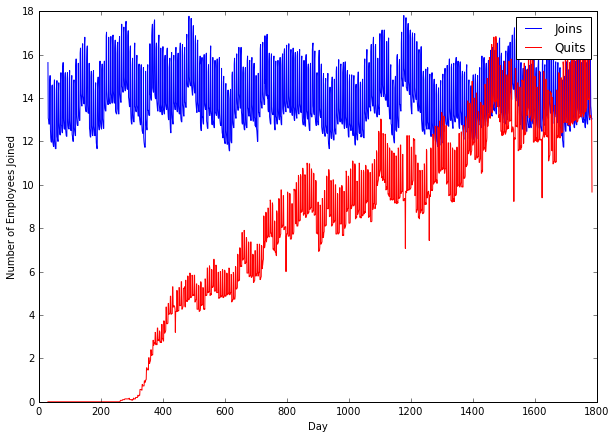

In [46]:
# plotting code
fig, ax = plt.subplots(figsize=(10,7))
join_line = ax.plot(x, y_join_rolling, color='b')
quit_line = ax.plot(x, y_quit_rolling, color='r')

ax.set_xlabel('Day')
ax.set_ylabel('Number of Employees Joined')
ax.legend((join_line[0], quit_line[0]),('Joins','Quits'))

plt.show()

Hmmm. The data is very noisy, and all this shows is that while the number of people who join stays relatively constant, the number of people who quit everyday starts to increase starting around day 300. And by the time you get to day ~1500 (about 4.5 years), the number of people quitting and joining are roughly the same.

Instead of this, let's take a look at histogram of how long each employee works before quitting. 

In [24]:
# calculate employment length by taking the difference between quit_date and join_date
employees['employment_length'] = pd.to_datetime(employees['quit_date'], dayfirst=True) - pd.to_datetime(employees['join_date'], dayfirst=True)
# dt.days attribute converts pandas datetime object to a float for histogram purposes
employees['employment_length'].dt.days

0         585.0
1         340.0
2           NaN
3         389.0
4        1040.0
5         578.0
6           NaN
7           NaN
8        1047.0
9           NaN
10        837.0
11          NaN
12        340.0
13       1194.0
14        340.0
15        409.0
16        723.0
17          NaN
18          NaN
19          NaN
20          NaN
21        340.0
22       1316.0
23        360.0
24        368.0
25        619.0
26          NaN
27        347.0
28        795.0
29       1152.0
          ...  
24670     606.0
24671    1271.0
24672     280.0
24673     828.0
24674     417.0
24675     340.0
24676     310.0
24677     396.0
24678     333.0
24679       NaN
24680       NaN
24681       NaN
24682       NaN
24683       NaN
24684     423.0
24685    1033.0
24686     371.0
24687     655.0
24688       NaN
24689     445.0
24690    1452.0
24691       NaN
24692     424.0
24693       NaN
24694       NaN
24695    1151.0
24696     372.0
24697       NaN
24698       NaN
24699     780.0
Name: employment_length,

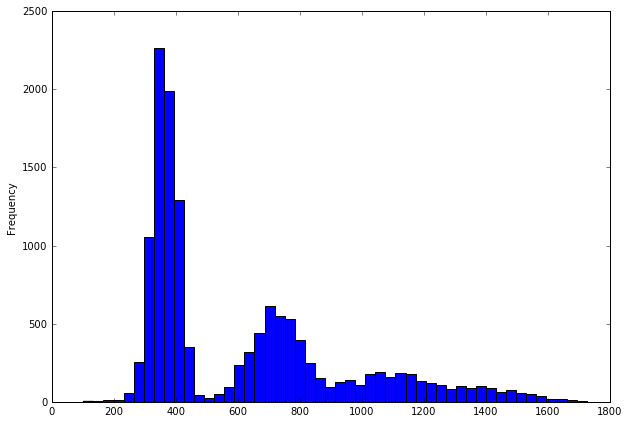

In [25]:
employees['employment_length'].dt.days.plot.hist(bins=50, figsize=(10,7))

Ok, so there's modulating peaks in the number of days worked before quitting. The single largest peak seems to be around the 1 year mark, with 2nd peak coming at 2 year mark, and another smaller peak at 3 year mark and so on...

Let's plot the employee headcount for each company throughout the year.

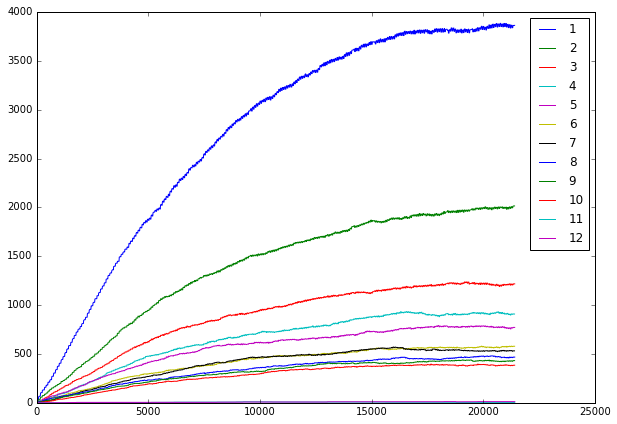

In [26]:
plt.figure(figsize=(10,7))
for key, group in headcount.groupby('company_id'):
    plt.plot(group['employee_headcount'], label=key)
plt.legend(loc='best')

As expected, most companies' headcount stabilizes after several years. We also note that the growth profile for each company looks similar, in that they all follow an inverse power law curve. This means that proportionally, similar number of employees join and quit each company at any given specific date.

## Machine Learning 
Now, let's shift focus to finding the best features for making an employee quit. It's natural for employees to quit after several years of work, since people switch in and out of careers, find new jobs, etc. 

But what is concerning for a company is if an employee quits early, say within 1 year. This means the employee is quitting after the company has invested time and money into making the employee effective. Let's find what are the most important features for what makes an employee quit early. 

We can create a binary class called **'quit_early'** which can take a value of either 0 or 1.
* 0 means the employee did not quit within 1.5 years.
* 1 means the employee quit within 1.5 year. We want to find what features are predominantly present in this group.

A decision tree should be plenty for this analysis. Let's set the limit to 1.5 years so that we capture most of the normal distribution around the 1 year anniversary quitters.

In [27]:
# create new column called 'quit_early' in accordance with markdown cell above
employees['quit_early'] = np.where(employees['employment_length'].dt.days <= 548, 1, 0)
employees.groupby('quit_early').count()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length
quit_early,,,,,,,,
0,17305,17305,17305,17305,17305,17305,6113,6113
1,7395,7395,7395,7395,7395,7395,7395,7395


Looks like about ~40% of the employees end up quitting early (within 1.5 years). Now create the decision tree.

In [28]:
# create the dataset to fit the tree
x_dt = employees[['dept','seniority','salary']]
x_dt = pd.get_dummies(x_dt,'dept')
y_dt = employees['quit_early']
x_dt

,seniority,salary,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,28,89000.0,1.0,0.0,0.0,0.0,0.0,0.0
1,20,183000.0,0.0,0.0,0.0,0.0,1.0,0.0
2,14,101000.0,0.0,0.0,0.0,0.0,1.0,0.0
3,20,115000.0,1.0,0.0,0.0,0.0,0.0,0.0
4,23,276000.0,0.0,1.0,0.0,0.0,0.0,0.0
5,14,165000.0,0.0,1.0,0.0,0.0,0.0,0.0
6,21,107000.0,1.0,0.0,0.0,0.0,0.0,0.0
7,4,30000.0,1.0,0.0,0.0,0.0,0.0,0.0
8,7,160000.0,0.0,0.0,0.0,1.0,0.0,0.0
9,7,104000.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
# fit to decision tree model with max_depth = 2 and min_samples_leaf = 1% of total dataset 
dt = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=len(y_dt)/100)
et_dt = dt.fit(x_dt,y_dt)

In [42]:
x_dt.columns[et_dt.tree_.feature]
x_dt.columns

Index([u'seniority', u'salary', u'dept_customer_service', u'dept_data_science',
       u'dept_design', u'dept_engineer', u'dept_marketing', u'dept_sales'],
      dtype='object')

Looks like the dominant features to split on were salary, and marketing department. Looking back at salary data for each department, we note that marketing has the 2nd lowest salary, although customer service has the lowest salary.

Let's visualize the tree to gain more insight.

In [43]:
# displays graphviz visualization of the decision tree on the notebook
def visualize_tree(dtree, feature_names):
    tree.export_graphviz(dtree, out_file='tree.dot')
    with open('tree.dot') as f:
        dot_graph = f.read()
        print dot_graph
    graphviz.Source(dot_graph)

In [44]:
visualize_tree(et_dt,x_dt.columns)

digraph Tree {
node [shape=box] ;
0 [label="X[1] <= 223500.0\ngini = 0.4195\nsamples = 24700\nvalue = [17305, 7395]"] ;
1 [label="X[1] <= 71500.0\ngini = 0.433\nsamples = 21124\nvalue = [14428, 6696]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[1] <= 60500.0\ngini = 0.3919\nsamples = 5147\nvalue = [3770, 1377]"] ;
1 -> 2 ;
3 [label="gini = 0.3789\nsamples = 3410\nvalue = [2544, 866]"] ;
2 -> 3 ;
4 [label="gini = 0.4153\nsamples = 1737\nvalue = [1226, 511]"] ;
2 -> 4 ;
5 [label="X[1] <= 181500.0\ngini = 0.4442\nsamples = 15977\nvalue = [10658, 5319]"] ;
1 -> 5 ;
6 [label="gini = 0.4484\nsamples = 12938\nvalue = [8547, 4391]"] ;
5 -> 6 ;
7 [label="gini = 0.4242\nsamples = 3039\nvalue = [2111, 928]"] ;
5 -> 7 ;
8 [label="X[1] <= 276500.0\ngini = 0.3145\nsamples = 3576\nvalue = [2877, 699]"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
9 [label="X[0] <= 17.5\ngini = 0.3573\nsamples = 1928\nvalue = [1479, 449]"] ;
8 -> 9 ;
10 [label="gin

When rendered in graphviz, this gives the condition of salary split at the root node of 223,500. It then splits more based mostly on salary. Seniority is also one of the nodes as well.

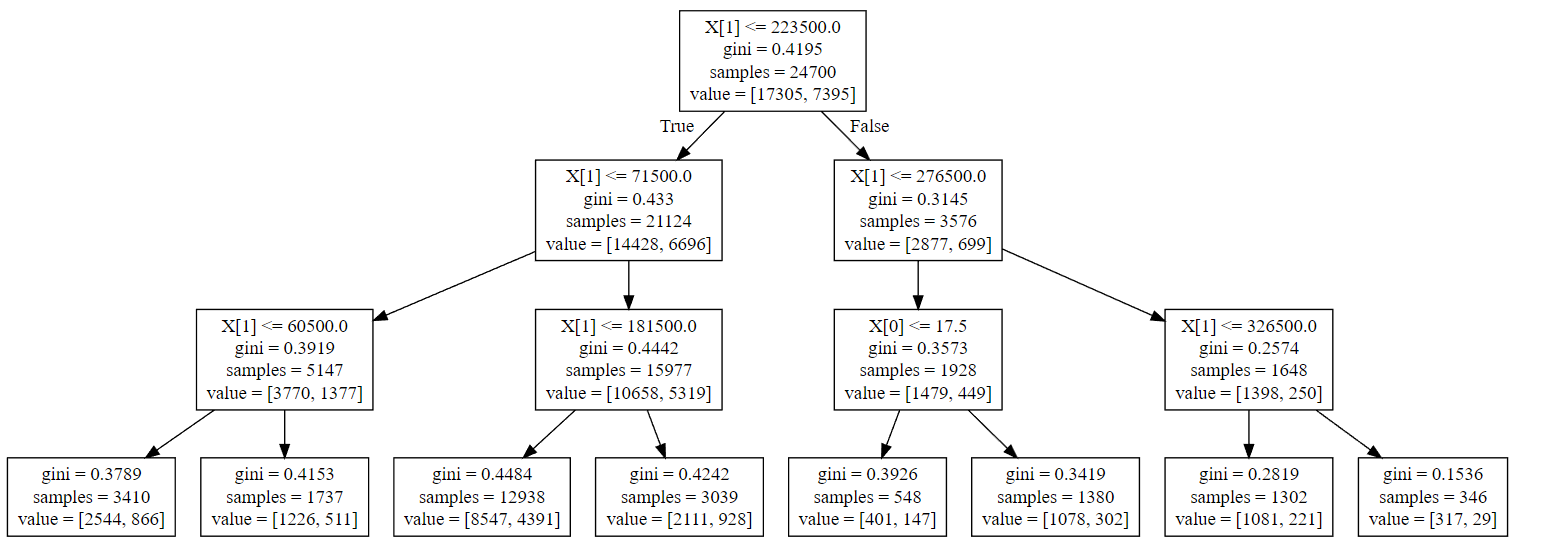

In [45]:
from IPython.display import Image
Image("dt.png")

Finally, to drive this point really home, let's plot portion of early quitters as a function of salary and seniority.

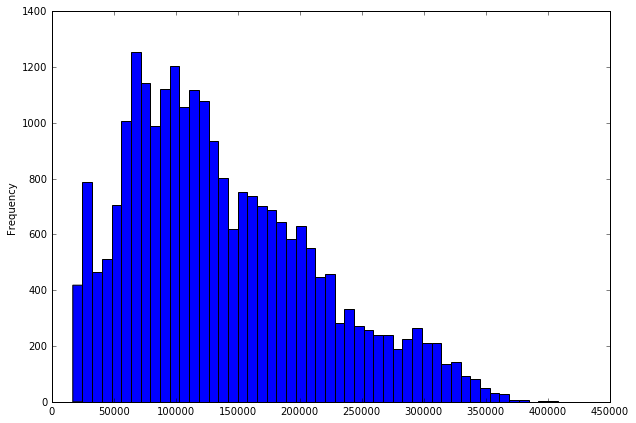

In [61]:
employees['salary'].plot.hist(bins=50, figsize=(10,7))

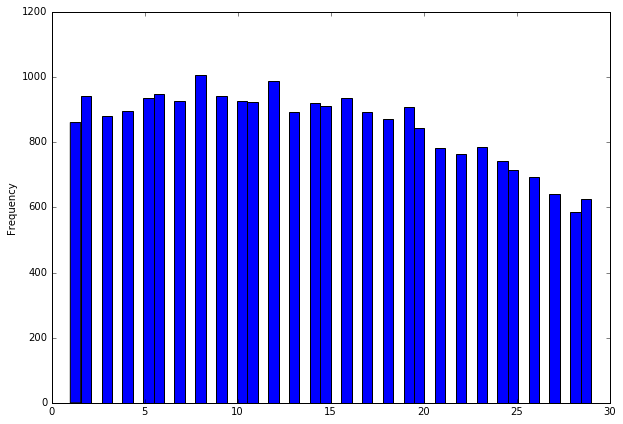

In [62]:
employees['seniority'].plot.hist(bins=50, figsize=(10,7))

We see a very clear trend for salary, and a decent trend for seniority after ~20 years or so for early quitters. 

However, for salary, we see something interesting. The quitter proportions are not highest at the lowest salary, it's slightly above that. You can see that the mode of plot is around 80,000 dollars.

## Conclusions

* Clearly, salary and seniority has an effect on the likeliness of an employee to quit, especially early (within 1.5 years). However, it's ot the lowest salaried employees who are most likely to quit, it's people just above this. There are few reasons for this. First is that the lowest salaried employees are often fresh out of college and need to build experience before moving to another company. Therefore, they are likely to stay beyond 1 year.


* We find that seniority has little effect on who quits until at around 20 years. This makes sense, as employees who have 20+ years of experience are likely looking to retire soon, and it does not make sense to leave a new job so early. They are looking to stay for a long time.


* One interesting variable to include would be employee performance. High performing employees who do not get the raise/bonus they deserve might be more likely to leave, and low performing employee may elect to stay since it would be hard to find a job. Another varible would be salary of next job for people who quit, since salary has such a strong correlation with quitting early. 